<a href="https://colab.research.google.com/github/jeffreykthomas/AAI-521-Final-Project/blob/main/DraftRSNA_Dina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm
! pip install --upgrade pydicom
#! pip install kaggle.input.pydicom_file.whl
#! pip install kaggle.input.gcdm_file.whl
! pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 84.8 MB/s eta 0:00:00


In [ ]:
# basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import confusion_matrix
import random
from PIL import Image

# specific for medical image data
import pydicom
pydicom.__version__

# PyTorch libraries
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#import torchvision.transforms as transforms
#import torchvision.models as models
#from torch.utils.data import Dataset

'2.4.2'

In [ ]:
# Read the csv data.
df_train = pd.read_csv('train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
df_train.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


In [ ]:
df_train_subset=df_train[['age','cancer','biopsy','invasive','BIRADS','implant']]
df_train_subset.corr()

,age,cancer,biopsy,invasive,BIRADS,implant
age,1.000000,0.075155,0.010167,0.068674,0.048258,-0.069599
cancer,0.075155,1.000000,0.613872,0.837815,-0.210718,-0.014311
biopsy,0.010167,0.613872,1.000000,0.514311,-0.410620,-0.002569
invasive,0.068674,0.837815,0.514311,1.000000,-0.172750,-0.008443
BIRADS,0.048258,-0.210718,-0.410620,-0.172750,1.000000,0.025262
implant,-0.069599,-0.014311,-0.002569,-0.008443,0.025262,1.000000


<Axes: >

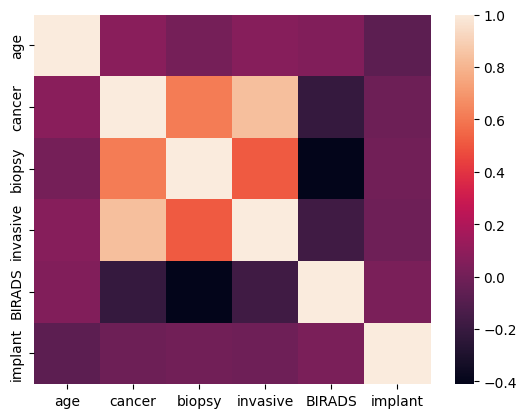

In [ ]:
# Create a correlation heatmap
sns.heatmap(df_train_subset.corr())

Display Meta Information
 Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0

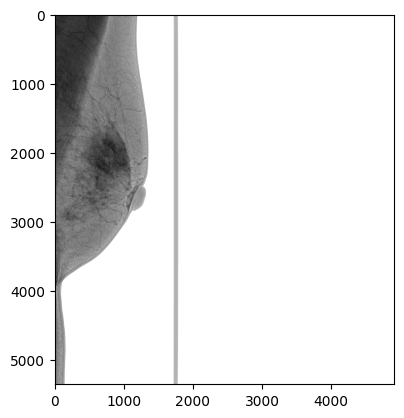

In [ ]:
#displaying sample image
sample_image = '1459541791.dcm'

ds = pydicom.dcmread(sample_image)
print("Display Meta Information\n", ds)

# Get information with keyword.
p_id = ds.PatientID
print("\n>Patient ID=", p_id, type(p_id))
img = ds.pixel_array
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


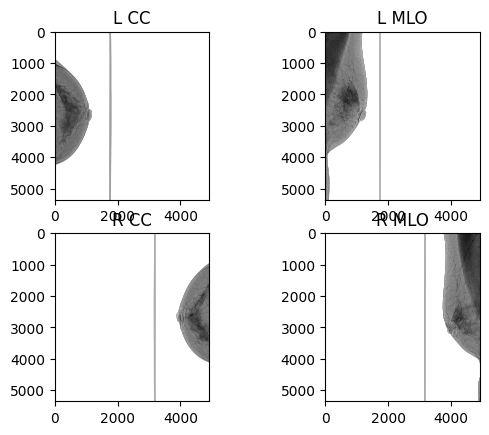

In [ ]:
#displaying sample image with no cancer
sample_image_L_CC = '462822612.dcm'
sample_image_L_MLO ='1459541791.dcm'
sample_image_R_CC =  '1874946579.dcm'
sample_image_R_MLO = '1864590858.dcm'
dsLCC = pydicom.dcmread(sample_image_L_CC)
dsLMLO = pydicom.dcmread(sample_image_L_MLO)
dsRCC = pydicom.dcmread(sample_image_R_CC)
dsRMLO = pydicom.dcmread(sample_image_R_MLO)

imgLCC = dsLCC.pixel_array
imgLMLO= dsLMLO.pixel_array
imgRCC = dsRCC.pixel_array
imgRMLO = dsRMLO.pixel_array
plt.subplot(2,2,1)
plt.title('L CC')
plt.imshow(imgLCC, cmap = 'gray')
plt.subplot(2,2,2)
plt.title('L MLO')
plt.imshow(imgLMLO, cmap = 'gray')
plt.subplot(2,2,3)
plt.title('R CC')
plt.imshow(imgRCC, cmap = 'gray')
plt.subplot(2,2,4)
plt.title('R MLO')
plt.imshow(imgRMLO, cmap = 'gray')
plt.show()

In [ ]:
df_train_cancer_positive=df_train[df_train['cancer']==1]

In [ ]:
df_train_cancer_positive[0:7]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False
191,1,10226,530620473,L,CC,71.0,1,1,1,0.0,0,C,49,False
215,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False


In [ ]:
patient_10130=df_train[df_train['patient_id']==10130]

In [ ]:
len(patient_10130)

7

In [ ]:
patient_10130[0:7]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
91,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False
92,1,10130,1165309236,R,CC,71.0,0,0,0,NaN,0,B,49,False
93,1,10130,2110820077,R,MLO,71.0,0,0,0,NaN,0,B,49,False


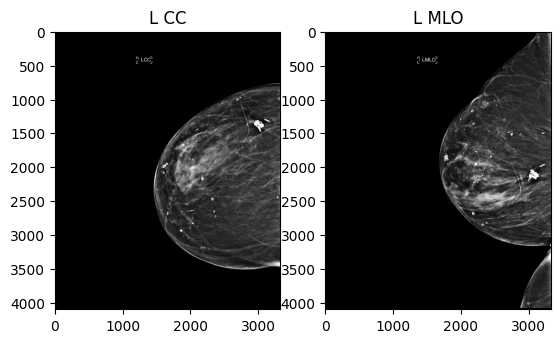

In [ ]:
#displaying sample image with cancer. Only L has cancer and R has no cancer
sample_image_L_CC = '613462606.dcm'
sample_image_L_MLO ='388811999.dcm'

dsLCC = pydicom.dcmread(sample_image_L_CC)
dsLMLO = pydicom.dcmread(sample_image_L_MLO)


imgLCC = dsLCC.pixel_array
imgLMLO= dsLMLO.pixel_array

plt.subplot(1,2,1)
plt.title('L CC')
plt.imshow(imgLCC, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('L MLO')
plt.imshow(imgLMLO, cmap = 'gray')

plt.show()

https://news.mit.edu/2021/robust-artificial-intelligence-tools-predict-future-cancer-0128

https://github.com/yala/Mirai

https://github.com/yala/OncoNet_Public


https://www.learningtocure.csail.mit.edu/